# Exercises day 03

In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy
from typing import Callable
from helper_functions import *

def compute_confidence_interval_sample(data : list[float], confidence : float = 0.95, normal : bool = False ) -> list[float]:
    """
        Compute the confidence interval of the mean of the data.
        :param data: list of data
        :param confidence: confidence level
        :param normal: whether of not the data is assumed normal distributed
        
        :return: confidence interval of the mean of the data
    """
    N = len(data)
    alpha = 1 - confidence

    data = np.array(data)
    if normal:
        conf_mean = [data.mean() - data.std()/np.sqrt(N) * scipy.stats.t.cdf(1-alpha/2, N - 1), data.mean() + data.std()/np.sqrt(N) * scipy.stats.t.cdf(1-alpha/2, N - 1)]
    else:
        conf_mean = [data.mean() - confidence * data.std()/np.sqrt(N), data.mean() + confidence * data.std()/np.sqrt(N)]
    
    return conf_mean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ex01
The event for the blocking system is has the possible following event:

* Arrival of a customer 
* Customer is served
* Customer is blocked, as all $m$ service unints is occupied.

For part 1 the arrival process is modelled as a Poisson process, and the service time distribution as exponential. For a poisson process wit the mean $\lambda$ we know that the intervals between the events are exponential distributied with the same parameter. We can use this information for sampling the arrival times for the system.

In [43]:
# Define blocking system
m = 10              # service units
SERVICE_MEAN = 8    # 1/mean service time
ARRIVAL_MEAN = 1    # mean arrival time      

The implementation of the simulations follows the event-by-event principle. As the method is quite simple one could sample all the arrivals beforehand, but this approuch is not always posible for other descrete events, so we choose to follow the event-by-event principle. Here all event are stored in an event list, that contrains the eventype and is sorted by the event time.

The simulation is initiated by the first arrival, and all service units are initialized to be free. The simulations then begins in a while loop until all of the choosen arrivals has happened. Here the next event is simply the next in the event list as the list is sorted by increasing time. The simulation should imitate the steady state probability of the blocking, the simulation should run a little time before counting the blocking rate. 

An event is handled differently compared to what kind of event it is. For an arrival we first check if there is free service unit. If there is one, and service time is sampled and added to the eventlist, of not the customer er blocked and the blocked customer count is encreased by one. For an departure a service unit is freed so that the number of occupied service units is decreases by one. The probability of blocking is therefore simply the blocking count devided by the total number of arrivals. 

The code for the simulation can be found in the python file `helper_functions`. Because you might be interested in other distributions for the arrival- and service time the simulation function takes two inputs that is the sampling from these distributions. The sampling function for the frist exercise is given as:

In [44]:
def sample_arrival_poisson_process() -> float:
    """
        Sample the arrival time from a Poisson process.
        
        :return: arrival time (as a float)
    """
    return np.random.exponential(ARRIVAL_MEAN) # TODO: check if is it not 1/arrial_mean


def sample_service_time_exponential() -> float:
    """
        Sample the service time from an exponential distribution.
        
        :return: service time (as a float)
    """
    return np.random.exponential(SERVICE_MEAN) 


The simulation gave the results:

In [45]:
block_fraction_initial, _ = blocking_simulation()

block_fraction_conf_initial = compute_confidence_interval_sample(block_fraction_initial)

print(f"The fraction of blocked customers \n{block_fraction_initial}")
print(f"Confidence interval for the mean blocking fraction: {block_fraction_conf_initial}")


run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
The fraction of blocked customers 
[0.1145, 0.114, 0.1206, 0.1289, 0.1128, 0.13, 0.1243, 0.1157, 0.1251, 0.1294]
Confidence interval for the mean blocking fraction: [0.11957014055988702, 0.12348985944011298]


Exact solution

In [46]:
A = ARRIVAL_MEAN * SERVICE_MEAN

B = (A**m/np.math.factorial(m))/np.sum([(A**i)/np.math.factorial(i) for i in range(m+1)])
print(f"Exact blocking probability: {B}")

Exact blocking probability: 0.12166106425295149


The simulation is sufficiently close to the found exact solution.

## EX02
The simulation is repeated with different arrival- and service time distributions. 

### a) Erlang distributed arrival


In [47]:
def sample_arrival_erlang() -> float:
    """
        Sample the arrival time from an erlang distribution with a = 1.
        (NOTE: a = 1, is apparently the mean value in SciPys implementation, idk we asked a TA)
        
        :return: arrival time (as a float)
    """
    return scipy.stats.erlang.rvs(a = 1)

In [48]:
block_fraction_erlang_arrival, _ = blocking_simulation(sample_arrival=sample_arrival_erlang)

block_fraction_conf_erlang_arrival = compute_confidence_interval_sample(block_fraction_erlang_arrival)

print(f"The fraction of blocked customers \n{block_fraction_erlang_arrival}")
print(f"Confidence interval for the mean blocking fraction: {block_fraction_conf_erlang_arrival}")

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
The fraction of blocked customers 
[0.1227, 0.1235, 0.1085, 0.1234, 0.122, 0.117, 0.1158, 0.124, 0.1206, 0.1242]
Confidence interval for the mean blocking fraction: [0.11873647234941212, 0.12160352765058788]


### b) hyper exponential distribution
For sampling from the hyper exponential distribution we utilize the Composition methods from last week

In [49]:


def sample_arrival_hyper_exponential() -> float:
    """
        Sample the arrival time from a hyper-exponential distribution.
        With probability 0.8 of having mean 1/0.8333 and probability 0.2 of having mean 1/5.
        
        :return: arrival time (as a float)
    """
    # The following two constants were ordained by Bo himself
    HYPER_PROB = 0.8
    HYPER_MEAN = [1/0.8333, 1/5.]

    first_exponential = np.random.binomial(n=1, p=HYPER_PROB)

    if first_exponential:
        return np.random.exponential(HYPER_MEAN[0])
    elif not first_exponential:
        return np.random.exponential(HYPER_MEAN[1])


Simulation:

In [50]:
block_fraction_hyper_exp, _ = blocking_simulation(sample_arrival=sample_arrival_hyper_exponential)

block_fraction_conf_hyper_exp = compute_confidence_interval_sample(block_fraction_hyper_exp)

print(f"The fraction of blocked customers \n{block_fraction_hyper_exp}")
print(f"Confidence interval for the mean blocking fraction: {block_fraction_conf_hyper_exp}")

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
The fraction of blocked customers 
[0.1433, 0.1485, 0.1318, 0.129, 0.138, 0.1397, 0.14, 0.1412, 0.1354, 0.1373]
Confidence interval for the mean blocking fraction: [0.13682922223425142, 0.14001077776574855]


## Ex03

**We reuse Poisson from** *Ex01* **but then we use some new distributions for sampling the service time**
* **Constant service time**
* **Paretto distributed with $k = 1.05$ or $k = 2.05$**
* **Choose some other distributions of our own volition**

### a) Constant service time

In [51]:
sample_service_time_constant = lambda : 8

In [52]:
block_fraction_const_service, _ = blocking_simulation(sample_service_time=sample_service_time_constant)

block_fraction_conf_const_service = compute_confidence_interval_sample(block_fraction_const_service)

print(f"The fraction of blocked customers \n{block_fraction_const_service}")
print(f"Confidence interval for the mean blocking fraction: {block_fraction_conf_const_service}")

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
The fraction of blocked customers 
[0.1312, 0.1133, 0.1188, 0.1246, 0.1221, 0.1282, 0.1263, 0.1209, 0.1202, 0.1243]
Confidence interval for the mean blocking fraction: [0.12153613060249555, 0.12444386939750449]


### b) Pareto distributed


In [53]:
k = 1.05 

def sample_service_time_pareto() -> float:
    """
        Sample the service time from an exponential distribution.
        
        :return: service time (as a float)
    """
    U = np.random.uniform(0.0, 1.0, 1)
    beta = (k - 1) / k
    return beta * (U**(-1 / k) - 1)


def pareto_samples(k, num_samples: int):
    U = np.random.uniform(0.0, 1.0, num_samples)
    beta = 8*(k - 1) / k
    X = beta*(U**(-1/k))

    return X

In [54]:
k_list = np.linspace(1.05, 2.05, 2) # <-- might just be one of the most insane lines of code I have ever seen
k_list = np.array([1.05, 2.05])

def sample_service_time_pareto(k) -> float:
    """
        Sample the service time from an pareto distribution.
        
        :return: service time (as a float) will be above 1
    """
    return scipy.stats.pareto.rvs(k)


Simulation with the different k values

In [55]:
pareto_confs = []
for k in k_list:
    print(f"Pareto with k={k}")
    temp_lambda = lambda : sample_service_time_pareto(k)
    block_fraction = blocking_simulation(sample_service_time=temp_lambda)
    block_fraction_conf = compute_confidence_interval_sample(block_fraction)

    pareto_confs.append(block_fraction_conf)    
    
print(pareto_confs)


Pareto with k=1.05
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
Pareto with k=2.05
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
[[0.2561873952652611, 0.8551097977090758], [0.16441034261843546, 0.8374835264618309]]


## Ex04
**Compare confidence intervals for Parts 1, 2, and 3 then interpret and explain differences if any.**


In [61]:
CONF_PATH = "conf_dict.npy"
# Save
confs_dict = {
    "initial_conf": block_fraction_conf_initial,
    "Erlang_conf": block_fraction_conf_erlang_arrival,
    "Hyper_exp_conf": block_fraction_conf_hyper_exp,
    "Const_conf": block_fraction_conf_const_service,
    "Pareto_conf": (pareto_confs, k_list)
    }
np.save(CONF_PATH, confs_dict)

# Load
confs_dict = np.load(CONF_PATH, allow_pickle='TRUE').item()

confidence interval for initial simulation: [0.11957014055988702, 0.12348985944011298]
Confidence interval for Erlang arrival: [0.11873647234941212, 0.12160352765058788]
Confidence interval for Hyperexp arrival: [0.13682922223425142, 0.14001077776574855]
Confidence interval constant service: [0.12153613060249555, 0.12444386939750449]
Confidence interval pareto, k=1.05: [0.2561873952652611, 0.8551097977090758]
Confidence interval pareto, k=2.05: [0.16441034261843546, 0.8374835264618309]


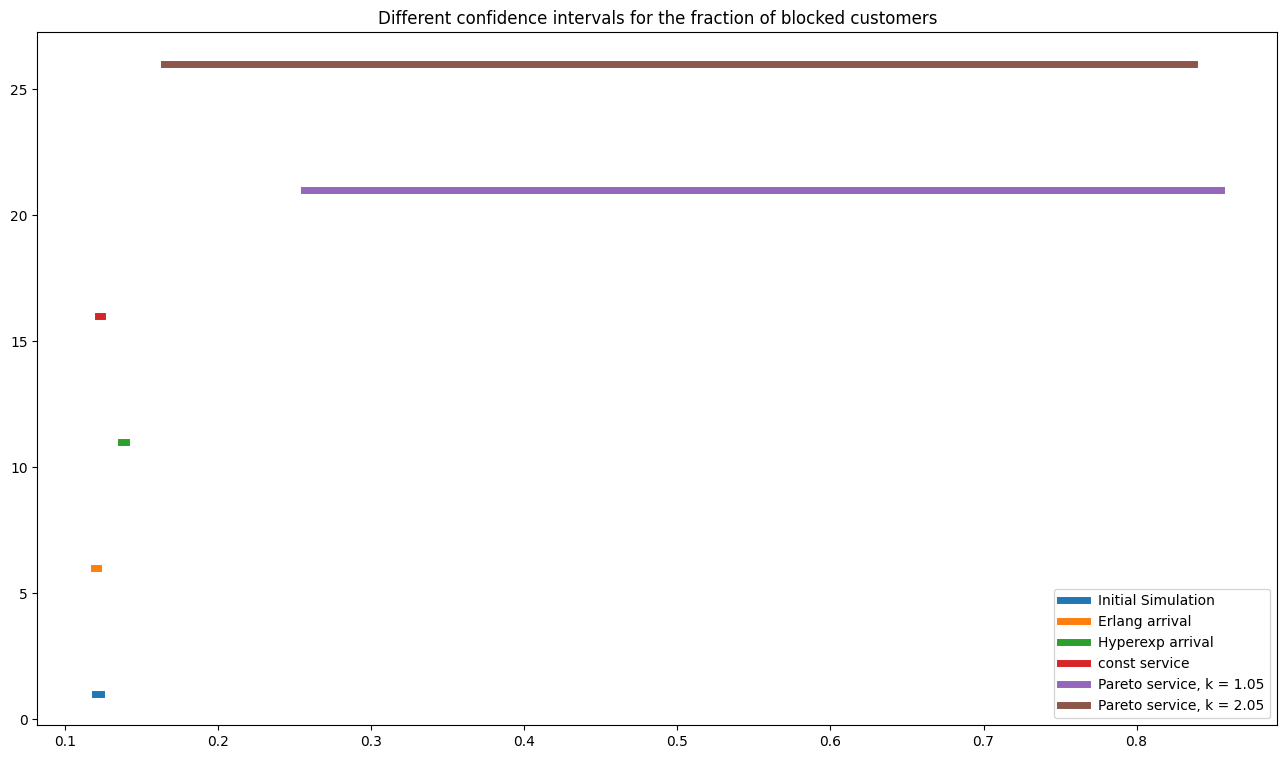

In [63]:
print(f"confidence interval for initial simulation: {confs_dict['initial_conf']}")
print(f"Confidence interval for Erlang arrival: {confs_dict['Erlang_conf']}")
print(f"Confidence interval for Hyperexp arrival: {confs_dict['Hyper_exp_conf']}")
print(f"Confidence interval constant service: {confs_dict['Const_conf']}")
print(f"Confidence interval pareto, k={confs_dict['Pareto_conf'][1][0]}: {confs_dict['Pareto_conf'][0][0]}")
print(f"Confidence interval pareto, k={confs_dict['Pareto_conf'][1][1]}: {confs_dict['Pareto_conf'][0][1]}")

size_between_y = 5
plt.figure(figsize=(16, 9))
plt.title("Different confidence intervals for the fraction of blocked customers")
plt.plot(block_fraction_conf_initial, [1, 1], label="Initial Simulation", linewidth=5)
plt.plot(block_fraction_conf_erlang_arrival, [1 + size_between_y*1, 1 + size_between_y*1], label="Erlang arrival", linewidth=5)
plt.plot(block_fraction_conf_hyper_exp, [1 + size_between_y*2, 1 + size_between_y*2], label="Hyperexp arrival", linewidth=5)
plt.plot(block_fraction_conf_const_service, [1 + size_between_y*3, 1 + size_between_y*3], label="const service", linewidth=5)
plt.plot(pareto_confs[0], [1 + size_between_y*4, 1 + size_between_y*4], label=f"Pareto service, k = {k_list[0]}", linewidth=5)
plt.plot(pareto_confs[1], [1 + size_between_y*5, 1 + size_between_y*5], label=f"Pareto service, k = {k_list[1]}", linewidth=5)
plt.legend()
plt.show()